# Определение возраста покупателей

## Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.


## Инструкция по выполнению проекта

- Проведите исследовательский анализ набора фотографий.
- Подготовьте данные к обучению.
- Обучите нейронную сеть и рассчитайте её качество.

## Исследовательский анализ данных

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
import seaborn as sns

In [32]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [14]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


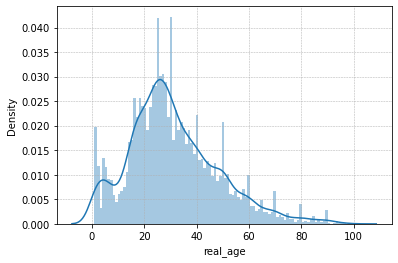

In [28]:
#Посмотрим распределение возраста
sns.distplot(labels["real_age"],  hist = True, bins=100)
plt.grid(linewidth = 0.5,    
        linestyle = '--')
plt.show()

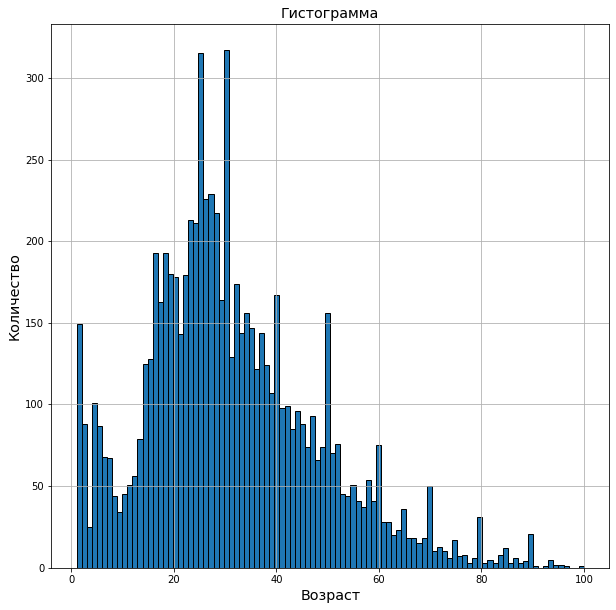

In [36]:
plt.figure(figsize=(10,10))
labels['real_age'].plot.hist(bins=100, grid=True, edgecolor='black')
plt.title('Гистограмма', fontsize='x-large')
plt.xlabel('Возраст', fontsize='x-large')
plt.ylabel('Количество', fontsize='x-large')
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


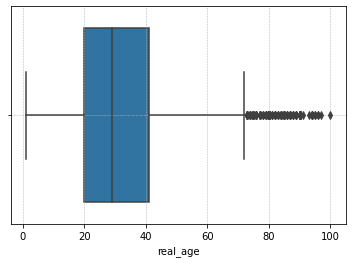

In [30]:
sns.boxplot(labels["real_age"])
plt.grid(linewidth = 0.5,    
        linestyle = '--')
plt.show()

Распределние признаков имеет некоторые особенности, с преобладанием фотографий людей в возрасте от 20 до 40 лет, и хвостом вправо. С опорой на бокс-плот можно сказать, что значения выше 75 можно считать аномальными.

In [33]:
features, target = next(train_gen)

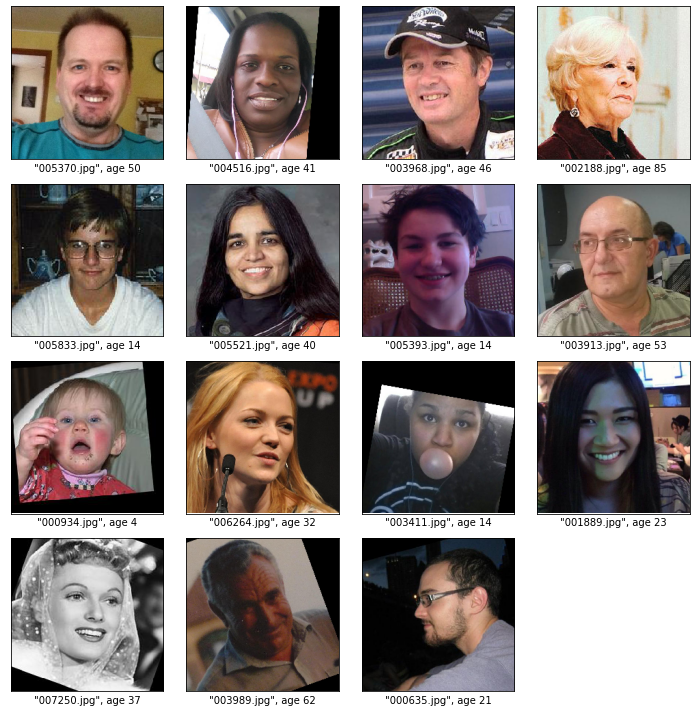

In [23]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(train_gen[0][0][i])
    plt.xlabel(
        f'"{train_gen.filenames[train_gen.index_array[i]]}", age {train_gen[0][1][i]}'
    )

    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Из выведенных фотографий мы можем сделать вывод, что проводилась первичная аугментация, некоторые изображения смещены и имеют искажения, сооветственно предварительная аугментация не требуется. Это так же указано в описании датасета.

Датасет так же содержит черно-белые изображения, кроме того изображения могут различаться по повороту, обрезке, смещению, размеру. Разница в размерах изображения учтена при предобработке.

Исходя из диаграммы разброса, большая часть фотографий принадлежит людям возрастом от 20 до 40 лет, выбросов небольшое количество.

На основании изученного можно сказать, что большинство людей в датасете имеют возраст от 20 до 35 лет.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

## Анализ обученной модели

Мы воспользовались моделью с ResNet, предобученной на ImageNet c слоями GlobalAveragePooling2D — пулинг с окном во весь тензор и Dense - полносвязный слой для классификации. ResNet — это глубокая сеть, которая применяет skip-connections, свёртки небольшого размера и bottleneck-блоки. На большинстве задач она работает лучше других архитектур.

Модель обучалась 10 эпохами с размером батча равном 32, оптимизатором Адам, сочетающим в себе идеи RMSProp и оптимизатора импульса, со скоростью обучения 0.0005, и горизонтальным поворотом.

При использовании данной модели, получили необходимую метрику MAE: наша модель предсказывает возраст с ошибкой ~ до 7 лет.